In [83]:
from datetime import datetime as dt

import keras.utils.vis_utils
import numpy as np
import pandas as pd
from IPython.core.display_functions import display
from dateutil.relativedelta import relativedelta
from keras import Sequential, layers, activations, losses, metrics
from keras.api.keras import optimizers

import file_helper
import tensorflow as tf
import plotly.graph_objects as go

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DATE_FORMAT = '%d.%m.%Y'

In [4]:
def convert_string_to_date(string_date: str) -> dt:
    return dt.strptime(string_date, DATE_FORMAT)

def normalize_columns_in_dataframe(data: pd.DataFrame, columns: list[str] = None) -> None:
    data_columns = data[columns]
    min_values = data_columns.min()
    max_values = data_columns.max()
    data[columns] = (data_columns - min_values) / (max_values - min_values)

In [5]:
geochem_data = pd.read_excel(file_helper.get_geo_chem_file_path(), 'dubki_h_tau')

In [6]:
events_catalog_data = pd.read_csv(file_helper.get_events_catalog_file_path(), sep=';').iloc[10000:]
events_catalog_data['Date'] = pd.to_datetime(events_catalog_data['Date'], format=DATE_FORMAT)

In [62]:
DATE_TARGET_OFFSET = relativedelta(years=1)
DATE_TARGET_DURATION = relativedelta(months=3)
STARTING_EVENT_CLASS = 13

In [63]:
preprocessed_data = pd.DataFrame(geochem_data)

normalize_columns_in_dataframe(preprocessed_data, ['events', 'ascend', 'maximum', 'descend', 'minimum'])

breakpoint_date = convert_string_to_date('31.12.2021') - DATE_TARGET_OFFSET - DATE_TARGET_DURATION
reserved_data = preprocessed_data[breakpoint_date < preprocessed_data['to date']].drop(['from date'], axis=1)
preprocessed_data = preprocessed_data[preprocessed_data['to date'] <= breakpoint_date]
preprocessed_data['target'] = preprocessed_data['to date'].map(lambda date: 1 if len(events_catalog_data[
    ((date + DATE_TARGET_OFFSET) <= events_catalog_data['Date'])
    & (events_catalog_data['Date'] <= (date + DATE_TARGET_OFFSET + DATE_TARGET_DURATION))
    & (STARTING_EVENT_CLASS <= events_catalog_data['Class'])
]) > 0 else 0)
preprocessed_data = preprocessed_data.drop(['from date', 'to date'], axis=1)

In [64]:
display(
    preprocessed_data.tail(),
    reserved_data.head()
)

,events,ascend,maximum,descend,minimum,target
5270,0.481203,0.421194,0.338960,0.697623,0.235527,0
5271,0.473684,0.451315,0.335375,0.705696,0.223079,0
5272,0.473684,0.451315,0.316563,0.684296,0.246268,0
5273,0.473684,0.426935,0.323147,0.684296,0.250121,0
5274,0.473684,0.426935,0.323147,0.684296,0.250121,0


,to date,events,ascend,maximum,descend,minimum
5275,2020-10-01,0.481203,0.421194,0.343562,0.697623,0.231859
5276,2020-10-02,0.488722,0.415862,0.352916,0.689861,0.230584
5277,2020-10-03,0.488722,0.415862,0.347748,0.689861,0.234706
5278,2020-10-04,0.496241,0.463999,0.341392,0.682098,0.225224
5279,2020-10-05,0.518797,0.446823,0.378052,0.660053,0.213775


In [65]:
x = preprocessed_data.drop(['target'], axis=1)
y = preprocessed_data['target']

In [66]:
RANDOM_STATE = 42
TRAIN_FRAC = .8

In [67]:
x_train, y_train = x.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE), y.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
x_test, y_test = x.drop(x_train.index), y.drop(y_train.index)

In [249]:
model = Sequential([
    layers.Dense(64, input_shape=(5,), name='dense_0'),
    layers.Dense(32, activation=activations.tanh, name='dense_1'),
    layers.Dense(16, activation=activations.tanh, name='dense_2'),
    layers.Dense(1, name='output')
])

In [250]:
model.compile(
    optimizer=optimizers.Adam(name='adam'),
    loss=losses.BinaryCrossentropy(name='binary_crossentropy', from_logits=True),
    metrics=[metrics.BinaryAccuracy(name='accuracy')]
)

In [251]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_split=.2,
    verbose=0
)

In [252]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


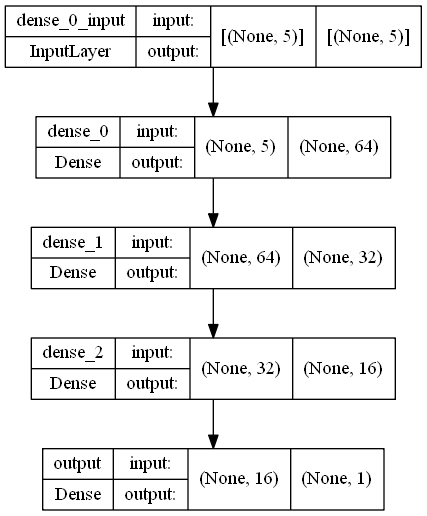

In [253]:
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [254]:
model.predict(x_test)

array([[-5.540551 ],
       [-5.540551 ],
       [-5.5571327],
       ...,
       [-4.8378644],
       [-5.876715 ],
       [-6.5450735]], dtype=float32)

In [255]:
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 12ms/step - loss: 0.1603 - accuracy: 0.9346


[0.16029009222984314, 0.9345971345901489]

In [256]:
history.history['val_accuracy'][-5:]

[0.920616090297699,
 0.9241706132888794,
 0.9111374616622925,
 0.920616090297699,
 0.9253554344177246]

In [257]:
reserved_data.head()

,to date,events,ascend,maximum,descend,minimum
5275,2020-10-01,0.481203,0.421194,0.343562,0.697623,0.231859
5276,2020-10-02,0.488722,0.415862,0.352916,0.689861,0.230584
5277,2020-10-03,0.488722,0.415862,0.347748,0.689861,0.234706
5278,2020-10-04,0.496241,0.463999,0.341392,0.682098,0.225224
5279,2020-10-05,0.518797,0.446823,0.378052,0.660053,0.213775


In [258]:
condition = (convert_string_to_date('1.1.2021') <= reserved_data['to date'])

X_pred = reserved_data[condition].drop(['to date'], axis=1)

# X_pred = processed_data[condition]

result_pred = model.predict(X_pred)
result_proba = tf.nn.sigmoid(result_pred).numpy()

In [259]:
reserved_data[condition]['to date']

5367   2021-01-01
5368   2021-01-02
5369   2021-01-03
5370   2021-01-04
5371   2021-01-05
          ...    
5728   2021-12-27
5729   2021-12-28
5730   2021-12-29
5731   2021-12-30
5732   2021-12-31
Name: to date, Length: 366, dtype: datetime64[ns]

In [260]:
figure_x = reserved_data[condition]['to date']
figure_x_text = figure_x.map(lambda e: f'[{(e + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(e + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=figure_x,
    y=1-result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    groupnorm='percent',
    name='No event',
    text=figure_x_text
))
fig.add_trace(go.Scatter(
    x=figure_x,
    y=result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    name='Event predicted',
    text=figure_x_text
))
fig.update_layout(
    title='Probability of event',
    # width=500, height=500
)
fig.show()

In [261]:
result = pd.DataFrame(reserved_data[condition])

In [262]:
result['predicted'] = result_pred
result[(result['predicted'] > 0)]['to date'].map(
    lambda date:
    f'K >= {STARTING_EVENT_CLASS}; Dates [{(date + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(date + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]'
)

5367    K >= 13; Dates [01.01.2022..01.04.2022]
5368    K >= 13; Dates [02.01.2022..02.04.2022]
5369    K >= 13; Dates [03.01.2022..03.04.2022]
5370    K >= 13; Dates [04.01.2022..04.04.2022]
5371    K >= 13; Dates [05.01.2022..05.04.2022]
                         ...                   
5728    K >= 13; Dates [27.12.2022..27.03.2023]
5729    K >= 13; Dates [28.12.2022..28.03.2023]
5730    K >= 13; Dates [29.12.2022..29.03.2023]
5731    K >= 13; Dates [30.12.2022..30.03.2023]
5732    K >= 13; Dates [31.12.2022..31.03.2023]
Name: to date, Length: 236, dtype: object